In [1]:
#importing required libraries
from keras.datasets import cifar100
from tensorflow import keras
import keras, os
import numpy as np
import tensorflow as tf
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, AvgPool2D
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Input, Softmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import Precision, Recall
from keras import optimizers
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras import backend as K
from keras import regularizers

In [2]:
num_classes = 100
train = True

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169009152/169001437 [==============================] - 8s 0us/step


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
# ResNet 18 model
x_shape = keras.Input((32, 32, 3))

# Stage 1
stage1_conv = keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, padding="SAME", activation = 'relu')(x_shape)
max_pool = keras.layers.MaxPool2D(padding="SAME")(stage1_conv)

# Stage 2
stage2_conv1 = Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(max_pool)
stage2_conv2 = Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage2_conv1)
stage2_skip1 = keras.layers.add([max_pool, stage2_conv2])

stage2_conv3 = Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage2_conv2)
stage2_conv4 = Conv2D(filters=64, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage2_conv3)
stage2_resize = Conv2D(filters=64, kernel_size=1, strides=2, padding="SAME")(stage2_skip1)
stage2_skip2 = keras.layers.add([stage2_resize, stage2_conv4])

# Stage 3
stage3_conv1 = Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage2_skip2)
stage3_conv2 = Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage3_conv1)
stage3_resize1 = Conv2D(filters=128, kernel_size=1, strides=1, padding="SAME")(stage2_skip2)
stage3_skip1 = keras.layers.add([stage3_resize1, stage3_conv2])

# stage3_conv3 = Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage3_skip1)
# stage3_conv4 = Conv2D(filters=128, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage3_conv3)
# stage3_resize2 = Conv2D(filters=128, kernel_size=1, strides=2, padding="SAME")(stage3_skip1)
# stage3_skip2 = keras.layers.add([stage3_resize2, stage3_conv4])

# Stage 4
stage4_conv1 = Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage3_skip1)
stage4_conv2 = Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage4_conv1)
stage4_resize1 = Conv2D(filters=256, kernel_size=1, strides=1, padding="SAME")(stage3_skip1)
stage4_skip1 = keras.layers.add([stage4_resize1, stage4_conv2])

# stage4_conv3 = Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage4_skip1)
# stage4_conv4 = Conv2D(filters=256, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage4_conv3)
# stage4_resize2 = Conv2D(filters=256, kernel_size=1, strides=2, padding="SAME")(stage4_skip1)
# stage4_skip2 = keras.layers.add([stage4_resize2, stage4_conv4])

# Stage 5
stage5_conv1 = Conv2D(filters=512, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage4_skip1)
stage5_conv2 = Conv2D(filters=512, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage5_conv1)
stage5_resize1 = Conv2D(filters=512, kernel_size=1, strides=1, padding="SAME")(stage4_skip1)
stage5_skip1 = keras.layers.add([stage5_resize1, stage5_conv2])

# stage5_conv3 = Conv2D(filters=512, kernel_size=3, strides=1, padding="SAME", activation = 'relu')(stage5_skip1)
# stage5_conv4 = Conv2D(filters=512, kernel_size=3, strides=2, padding="SAME", activation = 'relu')(stage5_conv3)
# stage5_resize2 = Conv2D(filters=512, kernel_size=1, strides=1, padding="SAME", activation = 'relu')(stage5_skip1)
# stage5_skip2 = keras.layers.add([stage5_resize2, stage5_conv4])

# Average Pooling
avg_pooling = AvgPool2D(strides=2)(stage5_skip1)

flat = Flatten()(avg_pooling)
dense10 = Dense(100)(flat)
softmax = Softmax()(dense10)

# Create Model
model = keras.Model(inputs=x_shape, outputs=softmax)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   36928       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [6]:
# Model compilation
model.compile(optimizer=SGD(lr=0.0001,decay= 1e-06, momentum=0.9, nesterov=True),
                loss='categorical_crossentropy',
                metrics=['accuracy', 'Precision', 'Recall'])

In [7]:
batch_size = 128
checkpoint = ModelCheckpoint("ResNet18_SGD_NoRegularization", monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=True, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=50, verbose=2, mode='auto')


datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             vertical_flip = False,
                             rotation_range = 10,
                             fill_mode = 'nearest',)

hist = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=200,
                    validation_data=(x_test, y_test),callbacks=[checkpoint, early],verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200

Epoch 00001: val_accuracy improved from -inf to 0.01160, saving model to ResNet18_SGD_NoRegularization
390/390 - 29s - loss: 5.3496 - accuracy: 0.0109 - precision: 0.0122 - recall: 1.6041e-04 - val_loss: 4.6022 - val_accuracy: 0.0116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200

Epoch 00002: val_accuracy improved from 0.01160 to 0.01420, saving model to ResNet18_SGD_NoRegularization
390/390 - 28s - loss: 4.6029 - accuracy: 0.0118 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.5958 - val_accuracy: 0.0142 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200

Epoch 00003: val_accuracy improved from 0.01420 to 0.02030, saving model to ResNet18_SGD_NoRegularization
390/390 - 28s - loss: 4.5878 - accuracy: 0.0168 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.5639 - val_accuracy: 0.0203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20

In [8]:
model.save_weights('ResNet18_SGD_NoRegularization.hf')
model.load_weights(filepath = 'ResNet18_SGD_NoRegularization')
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Precison: %.2f%%" % (scores[2]*100))
print("Recall: %.2f%%" % (scores[3]*100))

Accuracy: 49.19%
Precison: 64.63%
Recall: 40.68%


Text(0.5, 1.0, 'recall')

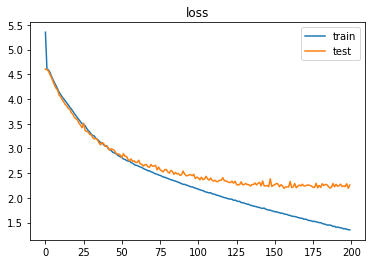

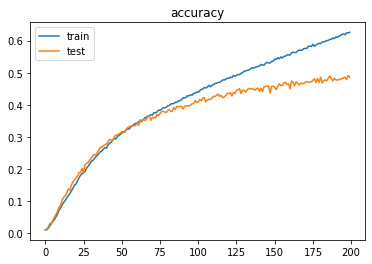

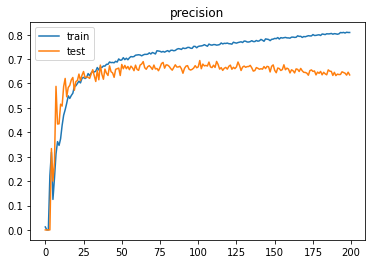

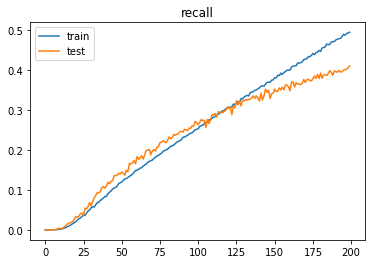

In [9]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.figure()
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.legend(['train','test'])
plt.title('precision')
plt.figure()
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.legend(['train','test'])
plt.title('recall')

REFERENCES
1. https://github.com/kklosowski/CIFAR10-with-Keras/blob/master/Cifar10Keras.ipynb
2. https://cv-tricks.com/keras/understand-implement-resnets/